# SAM-2 Video Interactive Segmentation Demo

In this demo, we apply **SAM-2** to video frames to segment objects **interactively**.
Changing the prompt over time shows how the model tracks objects and handles occlusions.

**课堂要点**
- 在第 0 帧用“点/框”初始化对象；
- 在第 20 帧再给新的提示（修正/切换目标），观察遮挡后如何继续跟踪；
- 输出整段视频的分割结果，并导出 GIF/MP4。

In [1]:
#@title Install & Imports
!pip -q install sam2 huggingface_hub opencv-python imageio matplotlib
import os, math, glob, io, contextlib
import numpy as np
import cv2, imageio.v2 as imageio
from PIL import Image
import torch
import matplotlib.pyplot as plt
from typing import List, Tuple
from sam2.sam2_video_predictor import SAM2VideoPredictor
print('Torch:', torch.__version__, '| CUDA available:', torch.cuda.is_available())

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.1 MB/s eta 0:00:00
Torch: 2.8.0+cu126 | CUDA available: True


In [2]:
#@title Prepare a small public video and extract frames
VIDEO_URL = "https://github.com/opencv/opencv/blob/master/samples/data/vtest.avi?raw=true"  # 行人视频
VIDEO_PATH = "/content/video.avi"
FRAME_DIR  = "/content/frames"
os.makedirs(FRAME_DIR, exist_ok=True)

!wget -q -O "$VIDEO_PATH" "$VIDEO_URL"
cap = cv2.VideoCapture(VIDEO_PATH)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 10

MAX_FRAMES = 80  # 课堂演示足够
frames_rgb = []
i = 0
while True:
    ok, frame_bgr = cap.read()
    if not ok or i >= MAX_FRAMES:
        break
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    frames_rgb.append(frame_rgb)
    cv2.imwrite(f"{FRAME_DIR}/{i:05d}.jpg", cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
    i += 1
cap.release()
len(frames_rgb), (w, h), fps

(80, (768, 576), 10.0)

In [3]:
#@title Load SAM-2 video predictor
MODEL_ID = "facebook/sam2-hiera-small"  # 速度/效果均衡；可换 large / base / tiny
predictor = SAM2VideoPredictor.from_pretrained(MODEL_ID)
inference_state = predictor.init_state(video_path=FRAME_DIR)  # 用帧目录初始化
print('SAM-2 state initialized with', MODEL_ID)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


sam2_hiera_small.pt:   0%|          | 0.00/184M [00:00<?, ?B/s]

frame loading (JPEG): 100%|██████████| 80/80 [00:03<00:00, 21.26it/s]


SAM-2 state initialized with facebook/sam2-hiera-small


In [4]:
#@title Define interactive prompts over time (points/boxes)
H, W = frames_rgb[0].shape[:2]

def make_point(x, y):
    # points shape: (N, 2); labels: 1=positive, 0=negative
    return np.array([[x, y]], dtype=np.float32), np.array([1], dtype=np.int32)

# 以 vtest.avi 的左侧行人为例：第0帧点一下；第20帧再点一下做修正
p1, l1 = make_point(int(W*0.30), int(H*0.65))
p2, l2 = make_point(int(W*0.35), int(H*0.62))

USER_PROMPTS = [
    {"frame_idx": 0,  "obj_id": 1, "points": p1, "labels": l1, "box": None},
    {"frame_idx": 20, "obj_id": 1, "points": p2, "labels": l2, "box": None},
]

# 如想用框提示：把 USE_BOX=True；并设置 box=np.array([x1,y1,x2,y2],dtype=np.float32)
USE_BOX = False
if USE_BOX:
    USER_PROMPTS = [
        {"frame_idx": 0,  "obj_id": 1, "points": None, "labels": None,
         "box": np.array([int(W*0.22), int(H*0.50), int(W*0.42), int(H*0.90)], dtype=np.float32)},
        {"frame_idx": 20, "obj_id": 1, "points": None, "labels": None,
         "box": np.array([int(W*0.26), int(H*0.48), int(W*0.46), int(H*0.88)], dtype=np.float32)},
    ]

USER_PROMPTS

[{'frame_idx': 0,
  'obj_id': 1,
  'points': array([[230., 374.]], dtype=float32),
  'labels': array([1], dtype=int32),
  'box': None},
 {'frame_idx': 20,
  'obj_id': 1,
  'points': array([[268., 357.]], dtype=float32),
  'labels': array([1], dtype=int32),
  'box': None}]

In [6]:
#@title Run interaction + propagate across the video; export GIF/MP4
import contextlib, numpy as np, torch, cv2, imageio
from PIL import Image

def overlay_mask(img_rgb: np.ndarray, mask: np.ndarray, alpha: float=0.5) -> np.ndarray:
    """把二值/布尔 mask 叠加到图像上显示。"""
    color = np.array([30, 180, 255], dtype=np.uint8)  # 青色
    overlay = img_rgb.copy()
    overlay[mask > 0] = (0.5*overlay[mask > 0] + 0.5*color).astype(np.uint8)
    return overlay

def to_np_uint8_mask(x):
    """把 Tensor/np 数组的 mask/ logits 统一成 np.uint8 的 [H,W] 掩码。"""
    if isinstance(x, torch.Tensor):
        x = x.detach().to("cpu")
        # 有些接口返回的是 logits，阈值 0 即可；若已是 bool/0-1 也能兼容
        x = (x > 0).to(torch.uint8).numpy()
    else:  # numpy
        x = (x > 0).astype(np.uint8)
    # 可能是 [1,H,W]，取第 0 维；若已是 [H,W] 不变
    if x.ndim == 3 and x.shape[0] == 1:
        x = x[0]
    return x  # [H,W] uint8

device = "cuda" if torch.cuda.is_available() else "cpu"
# T4 不支持 bfloat16，自动选择 AMP 精度
if device == "cuda":
    major_cc, _ = torch.cuda.get_device_capability(0)
    amp_dtype = torch.bfloat16 if major_cc >= 8 else torch.float16
    amp = torch.autocast("cuda", dtype=amp_dtype)
else:
    amp = contextlib.nullcontext()

rendered = {}
with torch.inference_mode(), amp:
    # 逐条交互提示：在指定帧添加点/框，立即返回该帧分割
    for step in USER_PROMPTS:
        fidx = step["frame_idx"]
        if step["points"] is not None:
            frame_idx, obj_ids, masks = predictor.add_new_points_or_box(
                inference_state,
                frame_idx=fidx, obj_id=step["obj_id"],
                points=step["points"], labels=step["labels"],
                normalize_coords=False,
            )
        else:
            frame_idx, obj_ids, masks = predictor.add_new_points_or_box(
                inference_state,
                frame_idx=fidx, obj_id=step["obj_id"],
                box=step["box"], normalize_coords=False,
            )

        # masks 可能是 [num_masks,H,W] 的 Tensor/np；统一到 uint8 numpy
        m0 = to_np_uint8_mask(masks[0])
        vis = overlay_mask(frames_rgb[fidx], m0)
        rendered[f"interact@{fidx:03d}.png"] = vis

    # 把当前交互态传播到整段视频
    out_frames = []
    for fidx, obj_ids, masks in predictor.propagate_in_video(inference_state):
        # 多目标时 masks 形状可能是 [num_objs,H,W]；做个并集演示
        if isinstance(masks, torch.Tensor):
            mm = (masks > 0).any(dim=0)         # -> [H,W] Tensor
            mm = to_np_uint8_mask(mm)           # -> [H,W] np.uint8
        else:
            mm = (masks > 0).any(axis=0).astype(np.uint8)
        vis = overlay_mask(frames_rgb[fidx], mm)
        out_frames.append(vis)

print("Frames rendered:", len(out_frames))

# 导出 GIF 和 MP4
GIF_PATH = "/content/sam2_result.gif"
MP4_PATH = "/content/sam2_result.mp4"
fps_safe = fps or 10

imageio.mimsave(GIF_PATH, [Image.fromarray(f) for f in out_frames], duration=max(1/fps_safe, 0.05))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vw = cv2.VideoWriter(MP4_PATH, fourcc, fps_safe, (w, h))
for f in out_frames:
    vw.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
vw.release()
print("Saved:", GIF_PATH, MP4_PATH)


propagate in video: 100%|██████████| 80/80 [00:12<00:00,  6.54it/s]


Frames rendered: 80
Saved: /content/sam2_result.gif /content/sam2_result.mp4


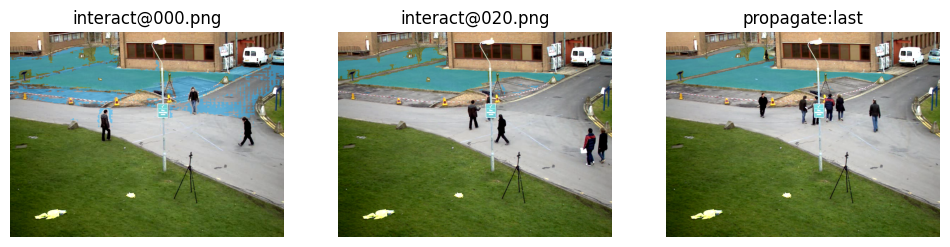

In [7]:
#@title Quick snapshots (see how prompts change results over time)
def show_images(imgs: List[Tuple[str, np.ndarray]], cols=3, size=4):
    rows = math.ceil(len(imgs)/cols)
    plt.figure(figsize=(cols*size, rows*size))
    for i, (title, im) in enumerate(imgs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.title(title)
        plt.axis('off')
    plt.show()

snapshots = []
for k in sorted(rendered.keys()):
    snapshots.append((k, rendered[k]))
snapshots.append(("propagate:last", out_frames[-1]))
show_images(snapshots, cols=3, size=4)

In [ ]:
#@title Download results (for report/assignment)
from IPython.display import FileLink, display
display(FileLink("/content/sam2_result.gif"))
display(FileLink("/content/sam2_result.mp4"))

## Notes
- 可把 `MODEL_ID` 改为 `facebook/sam2-hiera-large` 以获得更高精度（速度更慢）。
- 如要多目标，重复使用不同 `obj_id` 的提示即可；内部会维持各对象的状态并共同传播。
- 如需换自己的视频：上传到 `/content/your.mp4`，把 `VIDEO_PATH` 改成你的路径，重新解帧运行即可。